# Recommender System & Association Rules

Il dataset è reperibile al [seguente link](https://www.kaggle.com/datasets/rishitjavia/netflix-movie-rating-dataset?select=Netflix_Dataset_Movie.csv).

## Indice
1. [Analisi Statistiche](#analisi-statistiche)
2. [Clustering degli Utenti](#clustering-utenti)
3. [Mining delle Association Rules](#mining-delle-association-rules)
4. [Generazione Raccomandazioni](#generazione-raccomandazioni)
    - [Raccomandazioni Cluster-Based](#raccomandazioni-cluster-based)
    - [Raccomandazioni con Association Rules – Applicazione Diretta con Priorità](#raccomandazioni-con-association-rules--applicazione-diretta-con-priorità)
5. [Modelli in Post-Processing](#modelli-in-post-processing)
    - [Hybrid: Rules + Gradient Boosting](#hybrid-rule--gradient-boosting)
    - [Hybrid: Rules + XGBoost](#hybrid-rules--xgboost)
6. [Altre Strategie](#altre-strategie)
    - [Rule Base](#rule-base)
    - [FairMatch](#fairmatch)

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.cluster import MiniBatchKMeans
import pyfpgrowth
from collections import Counter, defaultdict
import ast
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from tqdm import tqdm
import ast
from sklearn.ensemble import GradientBoostingClassifier
import joblib
import xgboost as xgb

In [5]:
df_movies = pd.read_csv('./dataset/Netflix_Dataset_Movie.csv')
df_ratings = pd.read_csv('./dataset/Netflix_Dataset_Rating.csv')

## Analisi Statistiche

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie_ID  17770 non-null  int64 
 1   Year      17770 non-null  int64 
 2   Name      17770 non-null  object
dtypes: int64(2), object(1)
memory usage: 416.6+ KB
None
   Movie_ID  Year                          Name
0         1  2003               Dinosaur Planet
1         2  2004    Isle of Man TT 2004 Review
2         3  1997                     Character
3         4  1994  Paula Abdul's Get Up & Dance
4         5  2004      The Rise and Fall of ECW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17337458 entries, 0 to 17337457
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   User_ID   int64
 1   Rating    int64
 2   Movie_ID  int64
dtypes: int64(3)
memory usage: 396.8 MB
None
   User_ID  Rating  Movie_ID
0   712664       5         3
1  1331154       4         3
2  263

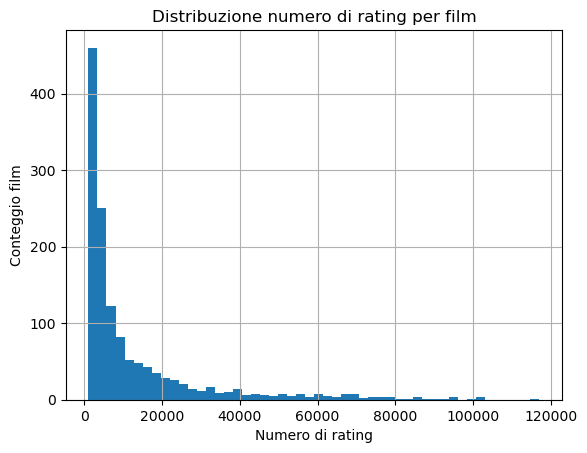

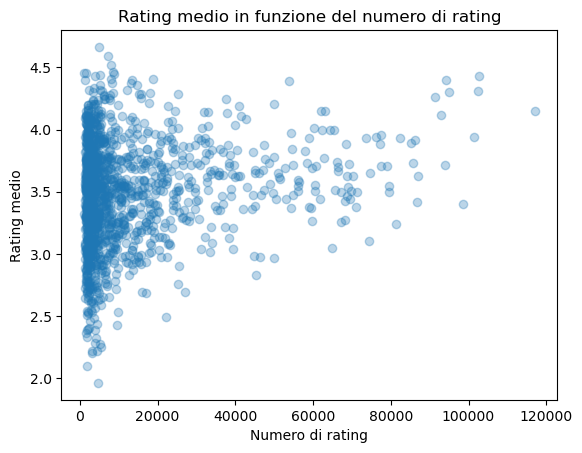

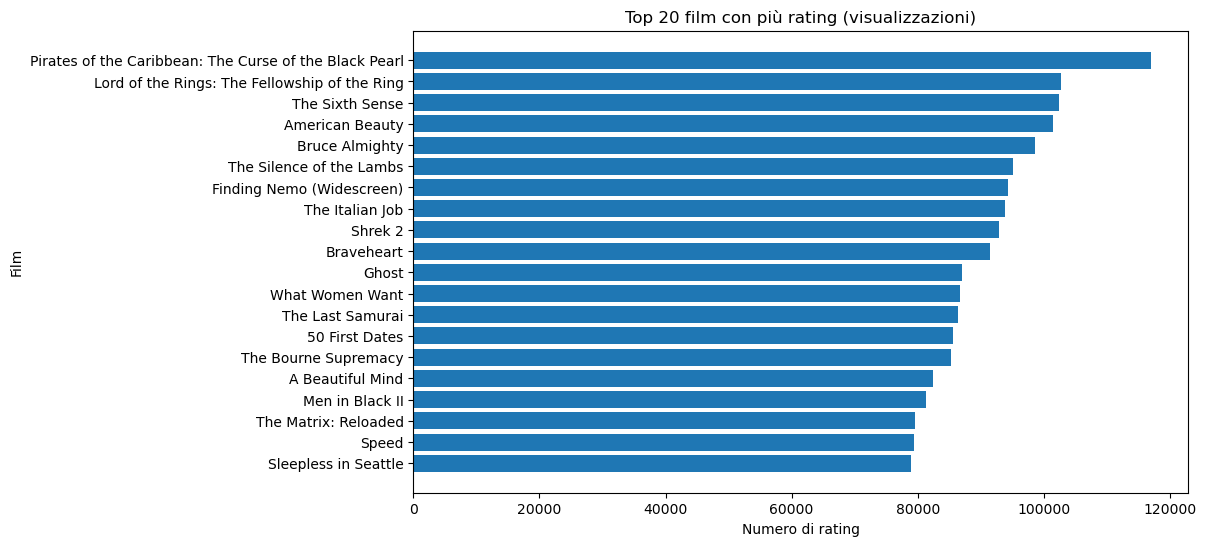

Numero totale di film: 17770
Film con almeno un rating: 1350
Film senza rating: 16420


In [7]:
print(df_movies.info())
print(df_movies.head())

print(df_ratings.info())
print(df_ratings.head())

movie_stats = (
    df_ratings
    .groupby("Movie_ID")
    .agg(
        avg_rating=("Rating", "mean"),
        num_ratings=("Rating", "count")
    )
    .reset_index()
)

num_unique_users = df_ratings['User_ID'].nunique()
print("Numero di utenti unici:", num_unique_users)

movie_stats = movie_stats.merge(df_movies, on="Movie_ID", how="left")

# Distribuzione numero di rating per film
movie_stats['num_ratings'].hist(bins=50)
plt.xlabel("Numero di rating")
plt.ylabel("Conteggio film")
plt.title("Distribuzione numero di rating per film")
plt.show()

# Rating medio vs numero di rating
plt.scatter(movie_stats['num_ratings'], movie_stats['avg_rating'], alpha=0.3)
plt.xlabel("Numero di rating")
plt.ylabel("Rating medio")
plt.title("Rating medio in funzione del numero di rating")
plt.show()

# Top 20 film più popolari
top_movies = movie_stats.sort_values("num_ratings", ascending=False).head(20)

plt.figure(figsize=(10,6))
plt.barh(top_movies["Name"], top_movies["num_ratings"])
plt.xlabel("Numero di rating")
plt.ylabel("Film")
plt.title("Top 20 film con più rating (visualizzazioni)")
plt.gca().invert_yaxis()  # così il più popolare sta in alto
plt.show()

# Statistiche dei film
total_movies = df_movies['Movie_ID'].nunique() # Numero totale di film
rated_movies = df_ratings['Movie_ID'].nunique() # Numero di film che hanno almeno un rating
unrated_movies = total_movies - rated_movies # Film senza alcun rating

print(f"Numero totale di film: {total_movies}")
print(f"Film con almeno un rating: {rated_movies}")
print(f"Film senza rating: {unrated_movies}")


Dalle analisi è emerso che:
- numero utenti: 143458
- numero film: 17770

Dopo aver preparato le transazioni, sarà necessario preparare una matrice booleana per poter applicare l'algoritmo Apriori. Tuttavia il numero di celle generate sarà 143.458 * 17.770 = 2.549.248.669 celle della matrice, che è troppo vasta ed in più sparsa. È quindi necessaria una riduzione del dataset, considerando solo gli utenti più attivi (con una lista di rating >= 50) e solo i film con più rating in assoluto (primi 1000).

Edit 1: poiché i costi computazionali sono elevati, si è deciso di seguire la strategia di **Apriori Association Rule for Course Recommender System**, che prevede una fase preliminare di clustering per raggruppare gli utenti simili. Le transazioni verranno estratte dai cluster e non dai singoli utenti.

Edit 2: verrà usato FP-Growth al posto di Apriori. Verranno utilizzati tutti i 1350 film con almeno una valutazione.

In [6]:
# utenti attivi
active_users = df_ratings.groupby('User_ID').size()
active_users = active_users[active_users >= 50].index  # utenti con >=50 rating
print(f"Numero di utenti attivi: {len(active_users)}")

# film popolari
popular_movies = df_ratings.groupby('Movie_ID').size().sort_values(ascending=False).head(1350).index

# filtro utenti attivi e film popolari
df_filtered = df_ratings[df_ratings['User_ID'].isin(active_users) & df_ratings['Movie_ID'].isin(popular_movies)].copy()
df_filtered['Liked'] = df_filtered['Rating'] >= 3

Numero di utenti attivi: 139962


## Clustering Utenti
Prima di eseguire il clustering, è necessario creare una matrice booleana utente-film, così da poter applicare l'algoritmo k-means (calcola le distanze euclidee tra vettori). È stato utilizzato il MiniBatchKMeans per dividere gli utenti in gruppi e ottimizzare le risorse.

Edit 1: è emerso che i film unici visti dagli utenti attivi (e cioè che hanno valutato 50+ film) sono 1350. 

Edit 2: cambio approccio per testare la qualità delle raccomandazioni effettuate. Gli utenti vengono separati in due gruppi: train (80%) e test (20%).

In [7]:
# Recupera tutti gli ID unici di utenti e film
user_ids = df_filtered['User_ID'].unique()
movie_ids = df_filtered['Movie_ID'].unique()

# Mappa gli ID originali a indici consecutivi, così da risalire agli originali se necessario
user_map = {uid:i for i, uid in enumerate(user_ids)}
movie_map = {mid:i for i, mid in enumerate(movie_ids)}

rows = df_filtered['User_ID'].map(user_map)
cols = df_filtered['Movie_ID'].map(movie_map)
data = df_filtered['Liked'].astype(int)

mat = csr_matrix((data, (rows, cols)), shape=(len(user_ids), len(movie_ids)))
print(f"Matrice booleana utenti-film di dimensione: {mat.shape}")

# Split 80-20 sugli utenti
train_users, val_users = train_test_split(user_ids, test_size=0.2, random_state=42)

# Mapping user_id - indice riga
user_idx_map = {uid: i for i, uid in enumerate(user_ids)}

train_idx = [user_idx_map[u] for u in train_users]
val_idx   = [user_idx_map[u] for u in val_users]

mat_train = mat[train_idx, :]
mat_val   = mat[val_idx, :]

# Clustering solo sul train
n_clusters = 1000
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000, random_state=42)

cluster_labels_train = kmeans.fit_predict(mat_train) # fit + labels train
cluster_labels_val = kmeans.predict(mat_val) # solo predict sul validation

# Si crea un array cluster_labels lungo quanto gli utenti totali
# Si riempie con le etichette di train e validation nelle posizioni giuste
# Per ogni utente si ha il cluster di appartenenza
cluster_labels = np.empty(len(user_ids), dtype=int)
cluster_labels[train_idx] = cluster_labels_train
cluster_labels[val_idx]   = cluster_labels_val

print("Clustering completato:")
print(f"- utenti train: {len(train_users)}")
print(f"- utenti validation: {len(val_users)}")

Matrice booleana utenti-film di dimensione: (139962, 1350)


Exception in thread Thread-29 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\simon\miniconda3\envs\fdsml\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\simon\miniconda3\envs\fdsml\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\simon\miniconda3\envs\fdsml\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\simon\miniconda3\envs\fdsml\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8a in position 123: invalid start byte


Clustering completato:
- utenti train: 111969
- utenti validation: 27993


## Mining delle Association Rules
Prima di procedere all'individuazione delle regole di associazione, è necessario preparare le transazioni. In questo caso:
- Ogni utente sarà considerato come un'unica transazione, quindi tutti i film che hanno ricevuto una valutazione dallo stesso utente saranno raggruppati;
- Ogni film sarà un item, ma verranno considerati solo film che hanno ricevuto un valore di Rating >= 3.

Così facendo, otterremo la lista di tutti i film piaciuti per utente.

Edit 1: poiché il numero di utenti é eccessivamente alto nonostante il filtro, si utilizzano i cluster.

Edit 2: dovendo valutare la bontà della strategia adottata, si è deciso di effettuare il mining delle association rules soltanto a partire dal train set (altrimenti si genererebbe data leakage).

In [8]:
train_df = df_filtered[df_filtered['User_ID'].isin(train_users)].copy()
train_df['Cluster'] = cluster_labels[train_df['User_ID'].map(user_map)]

transactions = (
    train_df[train_df['Liked']]
    .groupby('Cluster')['Movie_ID']
    .apply(lambda x: list(set(x)))
    .tolist()
)

print(len(transactions))

996


Poiché la memoria disponibile (16GB di RAM) non è sufficiente, allora verranno rimossi rari, cioè quelli che compaiono in un numero troppo basso di transazioni.

Edit 1: Si è deciso di non rimuovere alcun film.

In [8]:
movie_counts = Counter([m for t in transactions for m in t])
min_occurrence = 5  # soglia minima di cluster in cui deve comparire
keep_movies = {m for m, c in movie_counts.items() if c >= min_occurrence}

# filtra le transazioni
transactions = [[m for m in t if m in keep_movies] for t in transactions if any(m in keep_movies for m in t)]

print(f"Numero di film rimasti dopo filtraggio: {len(keep_movies)}")
print(f"Numero di transazioni finali: {len(transactions)}")

Numero di film rimasti dopo filtraggio: 1350
Numero di transazioni finali: 996


Dal passo precedente è stata prodotta una lista di tutte le transazioni. Successivamente è necessario convertire le transazioni in una matrice booleana, affinché possa essere applicato FP-Growth. 

Si è provato con Apriori, ma scala male sulla dimensione del dataset, arrivando a limitare:
- il numero di utenti: 143458 -> 18640 (rating >= 200)
- il numero di film: 17770 -> 1000 

Edit 1: usando i cluster al posto degli utenti, si passa da 143458 -> 500. Si comincia con un Supporto del 30% (valori di Supporto più bassi causano un'aumento del tempo d'esecuzione) e una Confidenza del 60%.

Edit 2: si usa pyfpgrowth per due ragioni:
- quando la matrice è troppa grande, FP-Growth risulta più efficiente di Apriori.
- Può lavorare direttamente su liste di liste, a differenza dell'algoritmo di mlxtend.

In [9]:
# 30% delle transazioni come soglia
support_threshold = int(0.3 * len(transactions))

# Trova pattern frequenti
patterns = pyfpgrowth.find_frequent_patterns(transactions, support_threshold)

# Genera regole (confidenza tra 0 e 1)
rules = pyfpgrowth.generate_association_rules(patterns, 0.6)

print(f"Trovati {len(patterns)} pattern frequenti")
print(f"Trovate {len(rules)} regole di associazione")


Trovati 3021 pattern frequenti
Trovate 1027 regole di associazione


I risultati prodotti vengono savlati come .csv

In [10]:
# Pattern frequenti
patterns_list = [(list(k), v) for k, v in patterns.items()]
df_patterns = pd.DataFrame(patterns_list, columns=['itemset', 'support'])
df_patterns.to_csv('./results/frequent_patterns.csv', index=False)

# Regole di associazione
rules_list = [(list(k), list(v[0]), v[1]) for k, v in rules.items()]
df_rules = pd.DataFrame(rules_list, columns=['antecedent', 'consequent', 'confidence'])
df_rules.to_csv('./results/association_rules.csv', index=False)

## Generazione Raccomandazioni

### Raccomandazioni Cluster-Based
Questa prima strategia di raccomandazione si basa esclusivamente sui film più popolari all’interno del cluster di appartenenza dell’utente. Il clustering viene costruito usando solo i dati del training set; di conseguenza, i film già visti in questa fase non vengono mai suggeriti. Per ciascun utente, vengono quindi raccomandati i titoli più apprezzati dagli altri membri del suo cluster, purché non facciano parte della sua cronologia di training.

Una hit si verifica quando un film raccomandato compare anche tra i film apprezzati dall’utente nel validation set. In altre parole, se un film è popolare nel cluster, non è stato visto dall’utente in training e risulta gradito nel validation, viene conteggiato come successo della raccomandazione.

In [ ]:
# Preparazione train e validation
train_df = df_filtered[df_filtered['User_ID'].isin(train_users)]
val_df   = df_filtered[df_filtered['User_ID'].isin(val_users)]

# Precalcolo user_history solo train: otterremo la lista di tutti i film piaciuti per utente.
user_history_dict = train_df[train_df["Liked"]].groupby("User_ID")["Movie_ID"].apply(list).to_dict()

# Precalcolo popolarità e ordinamento per cluster (solo train set)
cluster_popularity_sorted = {}
for c in np.unique(cluster_labels):
    # Seleziona solo gli utenti di train in questo cluster
    cluster_train_users = [user_idx_map[u] for u in train_users if cluster_labels[user_idx_map[u]] == c]
    if not cluster_train_users:
        cluster_popularity_sorted[c] = np.array([], dtype=int)
        continue
    cluster_mat = mat[cluster_train_users, :]  # csr_matrix
    # Calcola la popolarità (somma dei like) per ogni film nel cluster
    popularity = np.array(cluster_mat.sum(axis=0)).ravel()
    # Ordina i film per popolarità decrescente
    sorted_indices = np.argsort(-popularity)
    cluster_popularity_sorted[c] = sorted_indices

# Precalcolo liked_val per validation
# Crea un dizionario simile a user_history_dict, ma solo per gli utenti validation.
# Serve come ground truth: quali film hanno apprezzato realmente gli utenti validation.
val_df_liked_dict = val_df[val_df["Liked"]].groupby("User_ID")["Movie_ID"].apply(list).to_dict()

# 5. Funzione di raccomandazione a partire dai cluster
def recommend_from_clusters(user_id, cluster_labels, cluster_popularity_sorted, movie_ids, top_k=10):
    '''
    La funzione recupera il cluster dell'utente e raccomanda i film più popolari all'interno di quel cluster.
    Vengono raccomandati solo film che l'utente non ha ancora visto e che gli altri utenti del cluster hanno apprezzato.
    Se l'utente non è nel training set, restituisce i film più popolari globali.
    '''
    # Verifica se l'utente è presente in user_map
    if user_id in user_map:
        # Recupera cluster dell'utente
        user_idx = user_map[user_id]
        cluster_id = cluster_labels[user_idx]
        # Lista ordinata dei film più popolari nel cluster
        sorted_indices = cluster_popularity_sorted[cluster_id]
    else:
        # Per utenti non nel training set, usa popolarità globale
        all_popularity = np.concatenate(list(cluster_popularity_sorted.values()))
        sorted_indices = np.unique(all_popularity)
    
    # Recupera film già visti
    user_history = set(user_history_dict.get(user_id, []))
    
    # Filtra film già visti
    recs = [movie_ids[i] for i in sorted_indices if movie_ids[i] not in user_history]
    
    return recs[:top_k]

# Funzione di valutazione
def evaluate_user(user_id, cluster_labels, val_df_liked_dict, cluster_popularity_sorted, movie_ids, k=10):
    # Calcola le raccomandazioni per l'utente
    recs = recommend_from_clusters(user_id, cluster_labels, cluster_popularity_sorted, movie_ids, top_k=k)
    # Recupera i film che l'utente ha effettivamente apprezzato nel validation set
    liked_val = set(val_df_liked_dict.get(user_id, []))

    # Calcola precision e recall
    hits = len(set(recs) & liked_val)
    precision = hits / k
    recall = hits / len(liked_val) if liked_val else 0
    return precision, recall

# Valutazione su tutti gli utenti di validation
results = []
for user_id in val_users:
    prec, rec = evaluate_user(user_id, cluster_labels, val_df_liked_dict, cluster_popularity_sorted, movie_ids, k=10)
    results.append((prec, rec))

avg_precision = np.mean([p for p, _ in results])
avg_recall    = np.mean([r for _, r in results])

print("Precision@10:", avg_precision)
print("Recall@10:", avg_recall)

Precision@10: 0.7833029685992927
Recall@10: 0.09160918193891247


### Raccomandazioni con Association Rules – Applicazione Diretta con Priorità
In questa configurazione, le raccomandazioni di base ottenute dal clustering vengono arricchite con tutte le regole di associazione attivabili, ordinate per livello di confidence. I film suggeriti dalle regole hanno priorità e compaiono all’inizio della lista finale, mentre le raccomandazioni cluster-based vengono inserite solo in coda, per completare il ranking fino a k elementi. Non viene effettuato alcun processo di ottimizzazione o filtraggio delle regole oltre a questa ordinazione per confidence.

In [ ]:
# carico le regole
rules_df = pd.read_csv("./results/association_rules.csv")
rules_df["antecedent"] = rules_df["antecedent"].apply(ast.literal_eval)
rules_df["consequent"] = rules_df["consequent"].apply(ast.literal_eval)

# trasformo in dizionario per velocizzare la ricerca
rules_dict = {}
for _, row in rules_df.iterrows():
    rules_dict[tuple(row["antecedent"])] = (row["consequent"], row["confidence"])

# Funzione per applicare le regole con priorità
def apply_rules_to_recs_priority(user_id, recs, user_history_dict, rules_dict, top_k=10):
    """
    Migliora le raccomandazioni usando regole, aggiungendo film non visti dall'utente
    e ordinando per priorità: prima i film suggeriti dalle regole, poi quelli cluster-based.
    """
    user_history = set(user_history_dict.get(user_id, []))
    seen = set(user_history)  # film già visti
    
    # Ordina le regole per confidence decrescente
    sorted_rules = sorted(rules_dict.items(), key=lambda x: x[1][1], reverse=True)
    
    # Lista finale: prima tutti i film suggeriti dalle regole non visti
    recs_from_rules = []
    for antecedent, (consequents, conf) in sorted_rules:
        if set(antecedent).issubset(seen | set(recs)):
            for movie in consequents:
                if movie not in seen and movie not in recs_from_rules:
                    recs_from_rules.append(movie)
    
    # Poi aggiungiamo i suggerimenti cluster-based non ancora presenti
    for movie in recs:
        if movie not in recs_from_rules and movie not in seen:
            recs_from_rules.append(movie)
    
    # Ritorna i primi top_k
    return recs_from_rules[:top_k]

# Funzione di valutazione
def evaluate_user_with_rules_priority(user_id, cluster_labels, user_history_dict, val_df_liked_dict, cluster_popularity_sorted, movie_ids, rules_dict, k=10):
    # Raccomandazioni base cluster (puoi aumentare temporaneamente top_k per dare più spazio alle regole)
    recs = recommend_from_clusters(user_id, cluster_labels, cluster_popularity_sorted, movie_ids, top_k=k*2)
    # Miglioramento con regole prioritarie
    recs = apply_rules_to_recs_priority(user_id, recs, user_history_dict, rules_dict, top_k=k)
    
    # Calcola precision e recall
    liked_val = set(val_df_liked_dict.get(user_id, []))
    hits = len(set(recs) & liked_val)
    precision = hits / k
    recall = hits / len(liked_val) if liked_val else 0
    return precision, recall

# --- Valutazione su validation set ---
results_rules_priority = []
for user_id in val_users:
    prec, rec = evaluate_user_with_rules_priority(user_id, cluster_labels, user_history_dict, val_df_liked_dict, cluster_popularity_sorted, movie_ids, rules_dict, k=10)
    results_rules_priority.append((prec, rec))

avg_precision_rules_priority = np.mean([p for p, _ in results_rules_priority])
avg_recall_rules_priority    = np.mean([r for _, r in results_rules_priority])

print("Precision@10 con regole prioritarie:", avg_precision_rules_priority)
print("Recall@10 con regole prioritarie:", avg_recall_rules_priority)


Precision@10 con regole prioritarie: 0.7429357339334833
Recall@10 con regole prioritarie: 0.08577958383150831


## Modelli in Post-Processing
Questa sezione è finalizzata ad individuare dei modelli che possano migliorare i risultati ottenuti dalle regole. Prima di procedere all'applicazione dei modelli, sono necessari alcuni passi preliminari. Il primo riguarda la creazione di un dataset di addestramento per i modelli di machine learning. L’idea di fondo è trasformare il problema delle raccomandazioni in un classico problema di classificazione supervisionata.

Per ogni utente, vengono presi in considerazione i film candidati da suggerire. Questi candidati vengono scelti in due modi:
- dai film più popolari all’interno del cluster a cui appartiene l’utente,
- dai film proposti attraverso le regole di associazione che scaturiscono dalla sua cronologia di visione.

Una volta definiti i candidati, per ciascun film costruiamo un vettore di feature che descrive il legame tra l’utente e quel film attraverso la funzione `build_features`. Queste feature includono, quanto il film è popolare nel cluster, quanto è popolare a livello globale, quante regole lo suggeriscono e con quale livello di confidenza. A quel punto, associamo a ogni coppia (utente, film) un valore target:
- 1 se l’utente ha davvero apprezzato quel film (secondo la sua cronologia),
- 0 altrimenti.

Ripetendo questo processo per tutti gli utenti e i rispettivi film candidati, otteniamo una tabella finale in cui ogni riga rappresenta una coppia utente–film, le colonne contengono le feature, e la colonna target indica se quella raccomandazione sarebbe stata corretta o meno.
Infine, il dataset viene salvato in un file CSV, pronto per essere utilizzato rapidamente (il tempo per costruire il dataset è di circa 30 minuti).

In [19]:
# --- Variabili globali (tempo di esecuzione: ~35 secondi) ---

# Preparazione train e validation
train_df = df_filtered[df_filtered['User_ID'].isin(train_users)]
val_df   = df_filtered[df_filtered['User_ID'].isin(val_users)]

# Dizionario con regole di associazione
rules_df = pd.read_csv("./results/association_rules.csv")
rules_df["antecedent"] = rules_df["antecedent"].apply(ast.literal_eval)
rules_df["consequent"] = rules_df["consequent"].apply(ast.literal_eval)

rules_dict = {}
for _, row in rules_df.iterrows():
    rules_dict[tuple(row["antecedent"])] = (row["consequent"], row["confidence"])

# Precalcolo user_history con film apprezzati (solo train set)
user_history_dict = train_df[train_df["Liked"]].groupby("User_ID")["Movie_ID"].apply(list).to_dict()

# Precalcolo popolarità globale dei film (solo train set)
movie_popularity = dict(train_df.groupby("Movie_ID")["Liked"].sum())

# Precalcolo popolarità e ordinamento per cluster (solo train set)
cluster_popularity_sorted = {}
for c in np.unique(cluster_labels):
    cluster_train_users = [user_idx_map[u] for u in train_users if cluster_labels[user_idx_map[u]] == c]
    if not cluster_train_users:
        cluster_popularity_sorted[c] = np.array([], dtype=int)
        continue
    cluster_mat = mat[cluster_train_users, :]
    popularity = np.array(cluster_mat.sum(axis=0)).ravel()
    sorted_indices = np.argsort(-popularity)
    cluster_popularity_sorted[c] = sorted_indices

# Funzione per costruire le feature del dataset
def build_features(user_id, movie_id, cluster_labels, cluster_popularity_sorted, user_history_dict, rules_dict, movie_popularity, val_df_liked_dict=None):
    user_history = set(user_history_dict.get(user_id, []))
    user_idx = user_map[user_id]
    cluster_id = cluster_labels[user_idx]

    # Feature 1: rank popolarità nel cluster
    cluster_movies = cluster_popularity_sorted[cluster_id]
    cluster_rank = np.where(cluster_movies == np.where(movie_ids == movie_id)[0][0])[0]
    cluster_score = 1 / (1 + cluster_rank[0]) if len(cluster_rank) else 0

    # Feature 2: popolarità globale
    global_score = movie_popularity.get(movie_id, 0)

    # Feature 3: segnali dalle regole
    rule_conf, rules_triggered = 0, 0
    for antecedent, (consequents, conf) in rules_dict.items():
        if set(antecedent).issubset(user_history):
            if movie_id in consequents:
                rule_conf = max(rule_conf, conf)
                rules_triggered += 1

    # Target opzionale
    target = None
    if val_df_liked_dict is not None:
        target = int(movie_id in set(val_df_liked_dict.get(user_id, [])))

    return [cluster_score, global_score, rule_conf, rules_triggered], target

# funzione di valutazione ibrida ML + regole
def evaluate_hybrid_ml(clf, val_users, cluster_labels, user_map, cluster_popularity_sorted, movie_ids, 
    user_history_dict, rules_dict, movie_popularity, val_df_liked_dict, build_features, top_k_candidates=50,
    top_k_recs=10, verbose=True):

    results_ml = []

    for user_id in tqdm(val_users, desc="Valutazione su validation"):
        # Identifica cluster dell'utente
        cluster_id = cluster_labels[user_map[user_id]]

        # Prendi i film più popolari nel cluster
        candidates = set(movie_ids[cluster_popularity_sorted[cluster_id][:top_k_candidates]])

        # Recupera cronologia dell'utente
        user_history = set(user_history_dict.get(user_id, []))

        # Aggiungi film derivanti dalle regole di associazione
        for antecedent, (consequents, _) in rules_dict.items():
            if set(antecedent).issubset(user_history):
                candidates.update(consequents)

        # Costruisci features per i film candidati
        X_val, movies_val = [], []
        for movie_id in candidates:
            feats, _ = build_features(
                user_id, movie_id,
                cluster_labels,
                cluster_popularity_sorted,
                user_history_dict,
                rules_dict,
                movie_popularity,
                val_df_liked_dict
            )
            X_val.append(feats)
            movies_val.append(movie_id)

        if not X_val:
            continue  # nessun candidato

        # Predici probabilità di gradimento con il classificatore
        probs = clf.predict_proba(np.array(X_val))[:, 1]

        # Ordina i film per score predetto
        ranked_movies = [m for _, m in sorted(zip(probs, movies_val), reverse=True)]

        # Calcola precision e recall per l'utente
        liked_val = set(val_df_liked_dict.get(user_id, []))
        recs = ranked_movies[:top_k_recs]
        hits = len(set(recs) & liked_val)

        precision = hits / top_k_recs
        recall = hits / len(liked_val) if liked_val else 0

        results_ml.append((precision, recall))

    # Media sui risultati
    avg_precision = np.mean([p for p, _ in results_ml]) if results_ml else 0
    avg_recall = np.mean([r for _, r in results_ml]) if results_ml else 0

    if verbose:
        print(f"Precision@{top_k_recs}:", avg_precision)
        print(f"Recall@{top_k_recs}:", avg_recall)

    return avg_precision, avg_recall


Nota: Il blocco successivo è stato già eseguito e il csv generato. Meglio evitare di eseguirlo nuovamente.

In [ ]:
# Lista di feature e target
X_train, y_train = [], []

for user_id in tqdm(train_users, desc="Costruzione dataset train"):
    # Si cerca il cluster dell'utente
    cluster_id = cluster_labels[user_map[user_id]]
    # Genera i candidati a partire dai 100 film più popolari nel cluster
    candidates = set(movie_ids[cluster_popularity_sorted[cluster_id][:100]])
    for antecedent, (consequents, _) in rules_dict.items():
        # Se l'antecedent è nella cronologia dell'utente, aggiungi i consequents
        if set(antecedent).issubset(user_history_dict.get(user_id, [])):
            candidates.update(consequents)
    for movie_id in candidates:
        feats, _ = build_features(user_id, movie_id, cluster_labels, cluster_popularity_sorted, user_history_dict, rules_dict, movie_popularity)
        liked = int(movie_id in set(user_history_dict.get(user_id, [])))
        X_train.append(feats)
        y_train.append(liked)

# Trasforma in DataFrame e salva
columns = ["cluster_score", "global_score", "rule_conf", "rules_triggered"]
df_train = pd.DataFrame(X_train, columns=columns)
df_train["target"] = y_train

# Salva il dataset
df_train.to_csv("./dataset/train_dataset.csv", index=False)


### Hybrid: Rule + Gradient Boosting
In questa strategia le raccomandazioni non derivano solo dai film più popolari del cluster, ma vengono arricchite e filtrate attraverso un modello di Gradient Boosting. Il modello viene addestrato a prevedere la probabilità che l’utente apprezzi un film. Nella fase di valutazione, per ogni utente si generano fino a top_k_candidates (100) candidati, che includono sia film popolari nel cluster sia quelli suggeriti dalle regole. Questi candidati vengono poi ordinati in base alla probabilità stimata dal modello, e i primi top_k_recs (10) costituiscono la raccomandazione finale.

Il tempo di esecuzione medio della procedura è di circa 15 minuti.

In [ ]:
# Train/Validation Split (già definito)
train_df = df_filtered[df_filtered['User_ID'].isin(train_users)]
val_df   = df_filtered[df_filtered['User_ID'].isin(val_users)]

# Ground truth validation set: film apprezzati dagli utenti del validation set
val_df_liked_dict = val_df[val_df["Liked"]].groupby("User_ID")["Movie_ID"].apply(list).to_dict()

# Carica dataset già salvato
df_train = pd.read_csv("./dataset/train_dataset.csv")

# Separa features e target
X = df_train[["cluster_score", "global_score", "rule_conf", "rules_triggered"]].values
y = df_train["target"].values

# Allena modello
print("Training modello Gradient Boosting...")
clf = GradientBoostingClassifier(verbose=1)
clf.fit(X, y)
print("Modello addestrato.")

# Esempio di utilizzo   
avg_precision_ml, avg_recall_ml = evaluate_hybrid_ml(
    clf, val_users, cluster_labels, user_map, cluster_popularity_sorted, movie_ids, 
    user_history_dict, rules_dict, movie_popularity, val_df_liked_dict, build_features,
    top_k_candidates=100, top_k_recs=10, verbose=True
)

Training modello Gradient Boosting...
      Iter       Train Loss   Remaining Time 
         1           1.3685           11.60m
         2           1.3547           11.46m
         3           1.3433           11.10m
         4           1.3340           10.82m
         5           1.3262           10.56m
         6           1.3199           10.39m
         7           1.3145           10.23m
         8           1.3100           10.05m
         9           1.3063            9.95m
        10           1.3032            9.82m
        20           1.2887            8.61m
        30           1.2835            7.55m
        40           1.2812            6.58m
        50           1.2800            5.47m
        60           1.2790            4.41m
        70           1.2783            3.29m
        80           1.2777            2.19m
        90           1.2773            1.09m
       100           1.2768            0.00s
Modello addestrato.


Valutazione su validation: 100%|██████████| 27993/27993 [07:06<00:00, 65.61it/s]

Precision@10: 0.7525595684635443
Recall@10: 0.08753714489516773


'\n# Valutazione dei risultati\nresults_ml = []\nfor user_id in tqdm(val_users, desc="Valutazione su validation"):\n    cluster_id = cluster_labels[user_map[user_id]]\n    candidates = set(movie_ids[cluster_popularity_sorted[cluster_id][:50]])\n    user_history = set(user_history_dict.get(user_id, []))\n\n    for antecedent, (consequents, _) in rules_dict.items():\n        if set(antecedent).issubset(user_history):\n            candidates.update(consequents)\n\n    X_val, movies_val = [], []\n    for movie_id in candidates:\n        feats, target = build_features(user_id, movie_id, cluster_labels, cluster_popularity_sorted, user_history_dict, rules_dict, movie_popularity, val_df_liked_dict)\n        X_val.append(feats)\n        movies_val.append(movie_id)\n\n    if not X_val:\n        continue\n\n    probs = clf.predict_proba(np.array(X_val))[:, 1]\n    ranked_movies = [m for _, m in sorted(zip(probs, movies_val), reverse=True)]\n\n    liked_val = set(val_df_liked_dict.get(user_id, [])

### Hybrid: Rules + XGBoost
Come suggerito in letteratura al seguente [Link](https://www.sciencedirect.com/science/article/abs/pii/S0920548924000163?utm_source=chatgpt.com), le raccomandazioni vengono generate combinando regole di associazione e un modello supervisionato basato su XGBoost. Per ottimizzare le prestazioni, gli iperparametri di XGBoost vengono selezionati tramite RandomizedSearchCV con validazione incrociata a 3 fold. Il modello migliore viene salvato e riaddestrato con bilanciamento delle classi (scale_pos_weight).

Anche in questo caso, per ciascun utente vengono generati 100 candidati (da cluster e regole) e ordinati in base alla probabilità predetta da XGBoost durante la validazione. I primi 10 vengono infine raccomandati.

In [13]:
# Carica dataset
df_train = pd.read_csv("./dataset/train_dataset.csv")
X = df_train[["cluster_score", "global_score", "rule_conf", "rules_triggered"]].values
y = df_train["target"].values

# Train/Test split per tuning
X_tr, X_val_split, y_tr, y_val_split = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Nello snippet seguente viene eseguita una ricerca casuale degli iperparametri di XGBoost tramite `RandomizedSearchCV`. Il processo esplora diverse combinazioni di parametri (numero di alberi, profondità massima, tasso di apprendimento, sottocampionamento, ecc.) per ottimizzare le prestazioni del modello. Al termine della ricerca, il miglior modello trovato viene salvato su file per un successivo riutilizzo.

Tempo di esecuzione: ~30 minuti.

In [ ]:
# Parametri da testare
param_dist = {
    "n_estimators": [200, 400, 600],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.1, 0.05, 0.02],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 0.1, 0.2]
}

# RandomizedSearchCV per ricerca iperparametri
search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("Avvio ricerca iperparametri...")
search.fit(X_tr, y_tr)

clf_best = search.best_estimator_
print("Miglior set di parametri trovato:", search.best_params_)

clf_best = search.best_estimator_
joblib.dump(clf_best, "./models/xgb_randomizedSearch_model.pkl")

Esecuzione di `XGBoost` con gli iperparametri individuati da RandomizedSeach.

In [14]:
# Bilanciamento classi (Film piaciuti vs non piaciuti)
scale_pos_weight = (len(y) - sum(y)) / sum(y)

# Addestramento finale con miglior modello per XGBoost
clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    use_label_encoder=False
)

# Rifit diretto sul validation set
clf_best = joblib.load("./models/xgb_randomizedSearch_model.pkl")

clf_best.fit(
    X_tr, y_tr,
    eval_set=[(X_val_split, y_val_split)],
    verbose=True
)

# Valutazione finale sul validation set completo
avg_precision_ml, avg_recall_ml = evaluate_hybrid_ml(
    clf_best, val_users, cluster_labels, user_map, cluster_popularity_sorted, movie_ids, 
    user_history_dict, rules_dict, movie_popularity, val_df_liked_dict, build_features,
    top_k_candidates=100, top_k_recs=10, verbose=True
)

c:\Users\simon\miniconda3\envs\fdsml\lib\site-packages\xgboost\training.py:183: UserWarning: [11:52:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-auc:0.67773
[1]	validation_0-auc:0.67947
[2]	validation_0-auc:0.68024
[3]	validation_0-auc:0.68101
[4]	validation_0-auc:0.68156
[5]	validation_0-auc:0.68187
[6]	validation_0-auc:0.68209
[7]	validation_0-auc:0.68230
[8]	validation_0-auc:0.68267
[9]	validation_0-auc:0.68293
[10]	validation_0-auc:0.68337
[11]	validation_0-auc:0.68368
[12]	validation_0-auc:0.68419
[13]	validation_0-auc:0.68443
[14]	validation_0-auc:0.68487
[15]	validation_0-auc:0.68522
[16]	validation_0-auc:0.68559
[17]	validation_0-auc:0.68604
[18]	validation_0-auc:0.68640
[19]	validation_0-auc:0.68685
[20]	validation_0-auc:0.68715
[21]	validation_0-auc:0.68752
[22]	validation_0-auc:0.68795
[23]	validation_0-auc:0.68814
[24]	validation_0-auc:0.68853
[25]	validation_0-auc:0.68872
[26]	validation_0-auc:0.68909
[27]	validation_0-auc:0.68954
[28]	validation_0-auc:0.68980
[29]	validation_0-auc:0.69015
[30]	validation_0-auc:0.69043
[31]	validation_0-auc:0.69073
[32]	validation_0-auc:0.69101
[33]	validation_0-au

Valutazione su validation: 100%|██████████| 27993/27993 [10:50<00:00, 43.01it/s]

Precision@10: 0.7397920908798629
Recall@10: 0.08610602373716544


## Altre Strategie
Di seguito verranno presentate altre strategie che mirano a migliorare la qualità dei suggerimenti generati, ma senza l'utilizzo di modelli di Machine Learning. 

### Rule Base
L’approccio si ispira all’articolo [Post–mining on Association Rule Bases](https://link.springer.com/chapter/10.1007/978-3-031-50485-3_2) di Seipel. L’idea centrale è che le regole di associazione grezze contengono spesso rumore, ridondanze o sono troppo generiche per essere utilizzate direttamente in un sistema raccomandativo. Il post-mining consiste quindi in un insieme di operazioni di filtraggio, selezione e riadattamento delle regole, utilizzando informazioni aggiuntive come i cluster degli utenti o metriche extra di popolarità, per identificare quali regole siano effettivamente utili.

Nel nuovo flusso sono presenti le seguenti funzioni principali:
1. `build_movie_clusters`: costruisce una mappa Movie_ID -> lista di cluster in cui il film è stato visto dagli utenti. Questa informazione è fondamentale per identificare il cluster più rappresentativo di ogni regola durante il post-mining.
2. `postmine_rules`: prende le regole di associazione generate sul training set e le assegna al cluster più rappresentativo dell'antecedente (cioè il cluster in cui gli item dell'antecedente compaiono per più utenti). Filtra inoltre le regole troppo corte (min_len) per ridurre rumore e regole generiche.
3. `evaluate_rule_base`: funzione di valutazione batch che genera raccomandazioni per gli utenti di validation combinando:
    - Film più popolari nel cluster dell’utente (popolarità locale).
    - Film suggeriti dalle regole post-minate, solo se il cluster della regola coincide con quello dell’utente.
    
Le due sorgenti vengono combinate con un peso alpha (default 0.7 per le regole) e le raccomandazioni finali vengono filtrate per non superare una soglia massima di assegnazioni per singolo film (max_per_item_ratio). La funzione restituisce Precision@k e Recall@k medi sul validation set.


In [ ]:
def build_movie_clusters(df_filtered, user_map, cluster_labels):
    '''
    Precalcola la mappa Movie_ID -> lista di cluster degli utenti che hanno visto il film.
    '''
    # Mappa utente -> cluster
    user_cluster_map = {u: cluster_labels[idx] for u, idx in user_map.items()}

    # Per ogni utente in df_filtered, aggiungi il suo cluster
    df_with_clusters = df_filtered.assign(cluster=df_filtered["User_ID"].map(user_cluster_map))

    # Mappa film in una lista di cluster
    movie_clusters = (
        df_with_clusters.groupby("Movie_ID")["cluster"]
        .apply(list)
        .to_dict()
    )
    return movie_clusters


def postmine_rules(rules_df, movie_clusters, min_len=2):
    '''
    Post-mining delle regole secondo Seipel:
    - rimuove antecedenti troppo piccoli (min_len)
    - assegna ogni regola al cluster più rappresentativo
    - produce un dizionario di regole
    '''
    rules_dict_post = {}

    for _, row in rules_df.iterrows():
        ant = tuple(row["antecedent"])
        cons = row["consequent"]
        conf = row["confidence"]

        if len(ant) < min_len:
            continue

        # Raccogli tutti i cluster degli item nell’antecedente
        all_clusters = [c for m in ant if m in movie_clusters for c in movie_clusters[m]]
        if not all_clusters:
            continue

        # Trova cluster più frequente
        cluster_mode = Counter(all_clusters).most_common(1)[0][0]

        rules_dict_post[ant] = (cons, conf, cluster_mode)

    return rules_dict_post

def evaluate_rule_base(
    train_df, val_users, val_df_liked_dict, user_ids, movie_ids, user_item_mat,
    cluster_labels, user_map, rules_df, top_k=10, candidate_k=30,
    max_per_item_ratio=0.05, batch_size=10000, min_rule_len=2, alpha=0.7, verbose=True
):
    n_users = len(user_ids)
    max_per_item = int(max_per_item_ratio * n_users)

    idx_to_user = {i: uid for i, uid in enumerate(user_ids)}
    idx_to_movie = {i: mid for i, mid in enumerate(movie_ids)}

    # Cronologia utenti (solo train)
    user_histories = (
        train_df[train_df["Liked"] == 1]
        .groupby("User_ID")["Movie_ID"]
        .apply(set)
        .to_dict()
    )

    # Precalcolo cluster dei film
    movie_clusters = build_movie_clusters(train_df, user_map, cluster_labels)

    # Post-mining delle regole
    postmine_rules_dict = postmine_rules(rules_df, movie_clusters, min_len=min_rule_len)

    # Conteggio globale per max_per_item
    item_counts = defaultdict(int)
    results = []

    for start in range(0, n_users, batch_size):
        end = min(start + batch_size, n_users)
        batch_indices = np.arange(start, end)

        for uidx in batch_indices:
            uid = idx_to_user[uidx]
            if uid not in val_users:
                continue

            history = user_histories.get(uid, set())
            cluster_id = cluster_labels[uidx]

            # Popolarità film nel cluster
            cluster_mask = (cluster_labels == cluster_id)
            cluster_users = user_item_mat[cluster_mask]
            movie_popularity = np.array(cluster_users.sum(axis=0)).ravel()
            candidate_idxs = np.argsort(-movie_popularity)

            # Selezione candidati dal cluster
            cluster_candidates = []
            for idx in candidate_idxs:
                mid = idx_to_movie[idx]
                if mid not in history and item_counts[mid] < max_per_item:
                    cluster_candidates.append(mid)
                if len(cluster_candidates) >= candidate_k:
                    break

            # Candidati dalle regole post-minate (solo se cluster coincide)
            rule_candidates = {}
            for antecedent, (consequents, conf, rule_cluster) in postmine_rules_dict.items():
                if rule_cluster != cluster_id:
                    continue
                if all(item in history for item in antecedent):
                    for c in consequents:
                        if c not in history:
                            rule_candidates[c] = max(rule_candidates.get(c, 0), conf)

            # Combina le due sorgenti
            combined = {}
            for i, m in enumerate(cluster_candidates):
                combined[m] = combined.get(m, 0) + (1-alpha)/(i+1)
            for i, (m, conf) in enumerate(sorted(rule_candidates.items(), key=lambda x: x[1], reverse=True)):
                combined[m] = combined.get(m, 0) + alpha/(i+1)

            final_recs = [m for m, _ in sorted(combined.items(), key=lambda x: x[1], reverse=True)][:top_k]

            # Calcolo precision e recall
            liked_val = set(val_df_liked_dict.get(uid, []))
            hits = len(set(final_recs) & liked_val)
            precision = hits / top_k if top_k else 0
            recall = hits / len(liked_val) if liked_val else 0
            results.append((precision, recall))

        if verbose:
            print(f"Batch {start}-{end} completato.")

    avg_precision = np.mean([p for p, _ in results]) if results else 0
    avg_recall = np.mean([r for _, r in results]) if results else 0

    if verbose:
        print(f"Precision@{top_k}: {avg_precision:.4f}")
        print(f"Recall@{top_k}: {avg_recall:.4f}")

    return avg_precision, avg_recall

cluster_rules_precision, cluster_rules_recall = evaluate_rule_base(
    train_df=train_df,
    val_users=val_users,
    val_df_liked_dict=val_df_liked_dict,
    user_ids=user_ids,
    movie_ids=movie_ids,
    user_item_mat=mat,
    cluster_labels=cluster_labels,
    user_map=user_map,
    rules_df=rules_df,
    top_k=10,
    candidate_k=30,
    max_per_item_ratio=0.05,
    batch_size=10000,
    min_rule_len=2,
    alpha=0.7,
    verbose=True
)

Batch 0-10000 completato.
Batch 10000-20000 completato.
Batch 20000-30000 completato.
Batch 30000-40000 completato.
Batch 40000-50000 completato.
Batch 50000-60000 completato.
Batch 60000-70000 completato.
Batch 70000-80000 completato.
Batch 80000-90000 completato.
Batch 90000-100000 completato.
Batch 100000-110000 completato.
Batch 110000-120000 completato.
Batch 120000-130000 completato.
Batch 130000-139962 completato.
Precision@10: 0.7839
Recall@10: 0.0917


### FairMatch
L’approccio si ispira all’articolo [Fairmatch: A graph-based approach for improving aggregate diversity in recommender systems](https://dl.acm.org/doi/abs/10.1145/3340631.3394860?casa_token=0ltiJyrC9o8AAAAA:yVNVHYLhriRRZr0TZpb81HE5gEpLmSQVhukV-pDPtV_ysvsMhan0A-VRmPUD2XHqEvr0n6NCZpGu). Nella versione originale, FairMatch costruisce un grafo bipartito utenti–item, su cui esegue un algoritmo di matching per favorire la diversità aggregata, limitando l’esposizione degli item più popolari. In questa implementazione, invece, viene utilizzata una strategia *greedy batch*, che mantiene lo spirito dell'algoritmo originale ma con un calcolo molto più scalabile. La pipeline è la seguente:
1. Definizione dei vincoli globali: si impone un limite di esposizione per ogni item (max_per_item_ratio), ovvero un film non può essere raccomandato a più di una certa frazione di utenti.
2. Costruzione delle cronologie utente: per ogni utente, si ricostruisce la lista dei film già visti/piaciuti (rating ≥ 3), in modo da evitare di raccomandare film già noti.
3. Batch processing: gli utenti vengono processati in batch di dimensione batch_size (default: 10.000) per ridurre il consumo di memoria e migliorare la velocità di esecuzione.
4. Candidate list per cluster: ogni utente viene assegnato al proprio cluster. Per il cluster, si calcolano le frequenze di gradimento dei film (popolarità) e si ordinano i film in ordine decrescente per ottenere una lista di candidati.
5. Selezione greedy con vincoli: per ciascun utente, si scorre la lista di candidati, includendo film non ancora visti e che non hanno superato il limite di esposizione (max_per_item). L’utente riceve i primi candidate_k film idonei.
6. Output finale: da questa lista di candidati si estraggono i primi top_k film, che costituiscono le raccomandazioni finali per l’utente.

Questa variante non costruisce esplicitamente il grafo bipartito né risolve il matching globale, ma applica una versione greedy vincolata che riduce la concentrazione dei film popolari e migliora la diversità aggregata, mantenendo tempi di calcolo molto contenuti.

Tempo di esecuzione: circa 35 secondi.

In [ ]:
def evaluate_fairmatch_batch(train_df, val_users, val_df_liked_dict, user_ids, movie_ids, user_item_mat,
    cluster_labels, top_k=10, candidate_k=30, max_per_item_ratio=0.05, batch_size=10000, verbose=True):

    n_users = len(user_ids)
    max_per_item = int(max_per_item_ratio * n_users)

    # Mapping indici <-> ID reali
    idx_to_user = {i: uid for i, uid in enumerate(user_ids)}
    idx_to_movie = {i: mid for i, mid in enumerate(movie_ids)}

    # Cronologia utenti (solo train)
    user_histories = (
        train_df[train_df["Liked"] == 1]
        .groupby("User_ID")["Movie_ID"]
        .apply(set)
        .to_dict()
    )

    item_counts = defaultdict(int)
    results = []

    # Batch processing
    for start in range(0, n_users, batch_size):
        end = min(start + batch_size, n_users)
        batch_indices = np.arange(start, end)

        for uidx in batch_indices:
            uid = idx_to_user[uidx]
            if uid not in val_users:
                continue  # valuta solo utenti validation

            cluster_id = cluster_labels[uidx]
            cluster_mask = (cluster_labels == cluster_id)
            cluster_users = user_item_mat[cluster_mask]

            # popolarità nel cluster
            movie_popularity = np.array(cluster_users.sum(axis=0)).ravel()
            candidate_idxs = np.argsort(-movie_popularity)

            history = user_histories.get(uid, set())
            selected = []

            for idx in candidate_idxs:
                mid = idx_to_movie[idx]
                if mid not in history and item_counts[mid] < max_per_item:
                    selected.append(mid)
                    item_counts[mid] += 1
                if len(selected) >= candidate_k:
                    break

            recs = selected[:top_k]

            # Calcolo precision e recall su validation
            liked_val = set(val_df_liked_dict.get(uid, []))
            hits = len(set(recs) & liked_val)

            precision = hits / top_k if top_k > 0 else 0
            recall = hits / len(liked_val) if liked_val else 0
            results.append((precision, recall))

        if verbose:
            print(f"Batch {start}-{end} completato.")

    avg_precision = np.mean([p for p, _ in results]) if results else 0
    avg_recall = np.mean([r for _, r in results]) if results else 0

    if verbose:
        print(f"Precision@{top_k}: {avg_precision:.4f}")
        print(f"Recall@{top_k}: {avg_recall:.4f}")

    return avg_precision, avg_recall

fairmatch_precision, fairmatch_recall = evaluate_fairmatch_batch(
    train_df=train_df,
    val_users=val_users,
    val_df_liked_dict=val_df_liked_dict,
    user_ids=user_ids,
    movie_ids=movie_ids,
    user_item_mat=mat,
    cluster_labels=cluster_labels,
    top_k=10,
    candidate_k=30,
    max_per_item_ratio=0.05,
    batch_size=10000
)



Batch 0-10000 completato.
Batch 10000-20000 completato.
Batch 20000-30000 completato.
Batch 30000-40000 completato.
Batch 40000-50000 completato.
Batch 50000-60000 completato.
Batch 60000-70000 completato.
Batch 70000-80000 completato.
Batch 80000-90000 completato.
Batch 90000-100000 completato.
Batch 100000-110000 completato.
Batch 110000-120000 completato.
Batch 120000-130000 completato.
Batch 130000-139962 completato.
Precision@10: 0.7069
Recall@10: 0.0800
